One of the problems with using the results from quantum chemical calculations with the RDKit is that typical QM output formats just include atoms and their positions: since the calculations don't need bond orders, they don't show up in the output.
The problem of assigning correct bond orders to the atoms in a molecule based solely on atomic positions (and the overall charge on the molecule) is a non-trivial one, and we've never had a good answer in the RDKit.

A few years ago Jan Jensen and his group published `xyz2mol`, an open-source, RDKit-based solution to this problem written in Python: https://github.com/jensengroup/xyz2mol. During this year's Google Summer of Code, Sreya Gogineni, did a C++ port of the Python code and integrated it into the RDKit core for the 2022.09 release. 
Here's the [project description](https://summerofcode.withgoogle.com/programs/2022/projects/ugO4HoEX) and here's Sreya's ["final report"](https://github.com/rdkit/rdkit/pull/5557) which is also the PR where we merged her changes into the RDKit core.

This post was originally just going to be a quick introduction to how to use that code. However, since I was having fun with it, I went ahead and did some testing on a bunch of 3D structures from QM9.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import rdkit
rdkit.__version__

'2022.09.1'

# Using rdDetermineBonds

To get some testing files, I downloaded some structures from the [QM9 dataset](https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904). Here's what those look like: 

In [2]:
!cat ../data/dsgdb9nsd_107313.xyz

19
gdb 107313	2.67642	1.59305	1.14971	3.3443	81.12	-0.2359	-0.0506	0.1853	1106.1507	0.159794	-385.918216	-385.909962	-385.909018	-385.950934	31.892	
C	 0.0645055554	 1.4843171326	 0.3723315122	-0.379845
C	-0.001915467	 0.0516984051	-0.1729357038	-0.277772
C	-1.4001624807	-0.5304376801	-0.1487075838	 0.233551
C	-1.9909553844	-1.0379429662	 1.1601625215	-0.307513
C	-1.7182271444	-1.9962888369	 0.0152208454	-0.158294
C	-2.905416575	-2.2627721735	-0.8489696604	-0.065615
C	-3.3347497536	-1.1525477782	-1.4661914556	-0.191532
C	-2.4353480328	-0.0114763902	-1.1388331005	 0.336742
O	-2.4853518918	 1.1093228549	-1.595794586	-0.340877
H	 1.0876615149	 1.8699729825	 0.3263064541	 0.106173
H	-0.5836533924	 2.142053447	-0.2101812431	 0.152698
H	-0.2626541721	 1.5210712578	 1.4170099662	 0.108877
H	 0.3710335675	 0.0343653078	-1.2041622283	 0.107526
H	 0.662791197	-0.6008609283	 0.4071642198	 0.091428
H	-1.3142481944	-1.0584396879	 2.0096409673	 0.122076
H	-3.0252533013	-0.8199288984	 1.4038330438	 0

Sreya also added an XYZ file format parser to the RDKit, but these files include a bunch of additional information that we need to strip out. Here's the code for that:

In [3]:
# the XYZ files from QM9 aren't really XYZ... clean them up:
def cleanup_qm9_xyz(fname):
    ind = open(fname).readlines()
    nAts = int(ind[0])
    # There are two smiles in the data: the one from GDB and the one assigned from the
    # 3D coordinates in the QM9 paper using OpenBabel (I think).
    gdb_smi,relax_smi = ind[-2].split()[:2]
    ind[1] = '\n'
    ind = ind[:nAts+2]
    for i in range(2,nAts+2):
        l = ind[i]
        l = l.split('\t')
        l.pop(-1)
        ind[i] = '\t'.join(l)+'\n'
    ind = ''.join(ind)
    return ind,gdb_smi,relax_smi

In [4]:
ind,gdb_smi,relax_smi = cleanup_qm9_xyz('../data/dsgdb9nsd_107313.xyz')
print(ind)


19

C	 0.0645055554	 1.4843171326	 0.3723315122
C	-0.001915467	 0.0516984051	-0.1729357038
C	-1.4001624807	-0.5304376801	-0.1487075838
C	-1.9909553844	-1.0379429662	 1.1601625215
C	-1.7182271444	-1.9962888369	 0.0152208454
C	-2.905416575	-2.2627721735	-0.8489696604
C	-3.3347497536	-1.1525477782	-1.4661914556
C	-2.4353480328	-0.0114763902	-1.1388331005
O	-2.4853518918	 1.1093228549	-1.595794586
H	 1.0876615149	 1.8699729825	 0.3263064541
H	-0.5836533924	 2.142053447	-0.2101812431
H	-0.2626541721	 1.5210712578	 1.4170099662
H	 0.3710335675	 0.0343653078	-1.2041622283
H	 0.662791197	-0.6008609283	 0.4071642198
H	-1.3142481944	-1.0584396879	 2.0096409673
H	-3.0252533013	-0.8199288984	 1.4038330438
H	-0.9412329872	-2.7436632889	 0.1278385726
H	-3.37329736	-3.2394582332	-0.9072563749
H	-4.2004762777	-1.0463782959	-2.1061677066



And now we can construct a molecule:

In [5]:
raw_mol = Chem.MolFromXYZBlock(ind)
print(raw_mol.GetNumAtoms(),raw_mol.GetNumBonds())

19 0


In [6]:
import py3Dmol
def draw_with_spheres(mol):
    v = py3Dmol.view(width=300,height=300)
    IPythonConsole.addMolToView(mol,v)
    v.zoomTo()
    v.setStyle({'sphere':{'radius':0.3},'stick':{'radius':0.2}});
    v.show()

In [7]:
draw_with_spheres(raw_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Of course that doesn't yet have bonds. Let's fix that.

Start with `rdDetermineBonds.DetermineConnectivity()`, this uses distances between atoms to determine where there should be bonds, but does not attempt to figure out bond orders.

In [8]:
from rdkit.Chem import rdDetermineBonds
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineConnectivity(conn_mol)

draw_with_spheres(conn_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Now we can use `rdDetermineBonds.DetermineBondOrders()` to figure out what the bond orders should be.

This requires the overall charge on the molecule (the default value of the charge is zero, so it's not technically necessary to provide it here, but we do so to be clear):

In [9]:
rdDetermineBonds.DetermineBondOrders(conn_mol,charge=0)
draw_with_spheres(conn_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

We can do both steps in a single call. This is the easiest way to use the code if you just want to look at the final bond orders:

In [10]:
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol,charge=0)
draw_with_spheres(conn_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

See if the SMILES we got agrees with the what QM9 says it should be:

In [11]:
cm = Chem.RemoveHs(conn_mol)
osmi = Chem.MolToSmiles(cm)
smi = Chem.CanonSmiles(relax_smi)
print(osmi,smi)
osmi==smi

CC[C@]12C[C@H]1C=CC2=O CC[C@]12C[C@H]1C=CC2=O


True

Yep... that's all good.

Let's do another example:

In [12]:
ind,gdb_smi,relax_smi = cleanup_qm9_xyz('../data/dsgdb9nsd_127185.xyz')
raw_mol = Chem.MolFromXYZBlock(ind)
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol,charge=0)
conn_mol
draw_with_spheres(conn_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Again, make sure we got it right:

In [13]:
cm = Chem.RemoveHs(conn_mol)
osmi = Chem.MolToSmiles(cm)
smi = Chem.CanonSmiles(relax_smi)
print(osmi,smi)
osmi==smi

CN(C=O)c1ccon1 CN(C=O)c1ccon1


True

Since this method needs the Hs to be there, it unfortunately won't be useful in assigning bond orders to the ligands from PDB structures... ah well.

# Testing the functionality on a bunch of molecules

Here's a little test to see how well the new functionality does on a randomly selected subset of [QM9](https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904).

Start by getting 10K random files from my local copy of QM9 (these, for obvious reasons, aren't in the gitub repo for this notebook) and preprocessing them:

In [14]:
import glob
import random
random.seed(0xf00d)

fns = list(glob.glob('/local/QM9/*.xyz'))
random.shuffle(fns)
fns = fns[:10000]


In [15]:
qm9_data = []
for fn in fns:
    d,gdb_smi,relax_smi = cleanup_qm9_xyz(fn)
    qm9_data.append((fn,d,gdb_smi,relax_smi))


I believe that QM9 doesn't have double bond stereo indicated in the SMILES, verify that:

In [16]:
has_dbl_bond_stereo=[]
for tpl in qm9_data:
    smi = tpl[-1]
    if smi.find('/') != -1 or smi.find('\\') != -1:
        print(tpl)

Here's the testing code. 

For each molecule we have two SMILES to compare to: 
1. `gdb_smi`: the SMILES from GDB that the QM9 authors used as input 
2. `relax_smi`: the SMILES generated by OpenBabel(?) from the optimized structure.

We'll start by seeing if we match `relax_smi` and, if that fails, compare to `gdb_smi`.

In [17]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
relax_fails = []
gdb_fails = []
for fn,ind,gdb_smi,relax_smi in qm9_data:
    # the RDKit can't parse some of the SMILES from QM9... skip those mols
    try:
        smi = Chem.CanonSmiles(relax_smi)
    except:
        continue
    mol = Chem.MolFromXYZBlock(ind)
    if mol is None:
        print(f'Could not parse {fn}')
        continue
    rdDetermineBonds.DetermineBonds(mol,charge=0)
    # remove double bond stereo:
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE:
            bond.SetStereo(Chem.BondStereo.STEREONONE)
        elif bond.GetBondType() == Chem.BondType.SINGLE:
            bond.SetBondDir(Chem.BondDir.NONE)
    osmi = Chem.MolToSmiles(Chem.RemoveAllHs(mol))
    # compare to relax_smi:
    if smi!=osmi:
        relax_fails.append((fn,smi,osmi))
        # that failed, so next we are going to compare to gdb_smi;
        try:
            smi = Chem.CanonSmiles(gdb_smi)
        except:
            continue
        # the GDB smiles don't have any stereo at all, so get rid of atomic stereo
        for atom in mol.GetAtoms():
            atom.SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        osmi = Chem.MolToSmiles(Chem.RemoveAllHs(mol))
        if smi != osmi:
            gdb_fails.append((fn,smi,osmi))
RDLogger.EnableLog('rdApp.*')

len(relax_fails),len(gdb_fails)

Could not parse /local/QM9/dsgdb9nsd_112773.xyz
Could not parse /local/QM9/dsgdb9nsd_071817.xyz
Could not parse /local/QM9/dsgdb9nsd_024513.xyz
Could not parse /local/QM9/dsgdb9nsd_057755.xyz
Could not parse /local/QM9/dsgdb9nsd_005005.xyz
Could not parse /local/QM9/dsgdb9nsd_132540.xyz
Could not parse /local/QM9/dsgdb9nsd_002091.xyz
Could not parse /local/QM9/dsgdb9nsd_025366.xyz
Could not parse /local/QM9/dsgdb9nsd_104557.xyz


(909, 27)

In [18]:
relax_fails[0]

('/local/QM9/dsgdb9nsd_130414.xyz', '[NH][C]1C=NOC(CN)=N1', 'N=c1cnoc(CN)n1')

In [19]:
gdb_fails[0]

('/local/QM9/dsgdb9nsd_130861.xyz', 'O=Cc1cc(=O)nno1', 'N#N.O=C=CC(=O)C=O')

Let's start by looking at some of the failures based on `relax_smi`.

In the output we have pairs of molecules where the first is constructed from `relax_smi` and the second is what we perceived

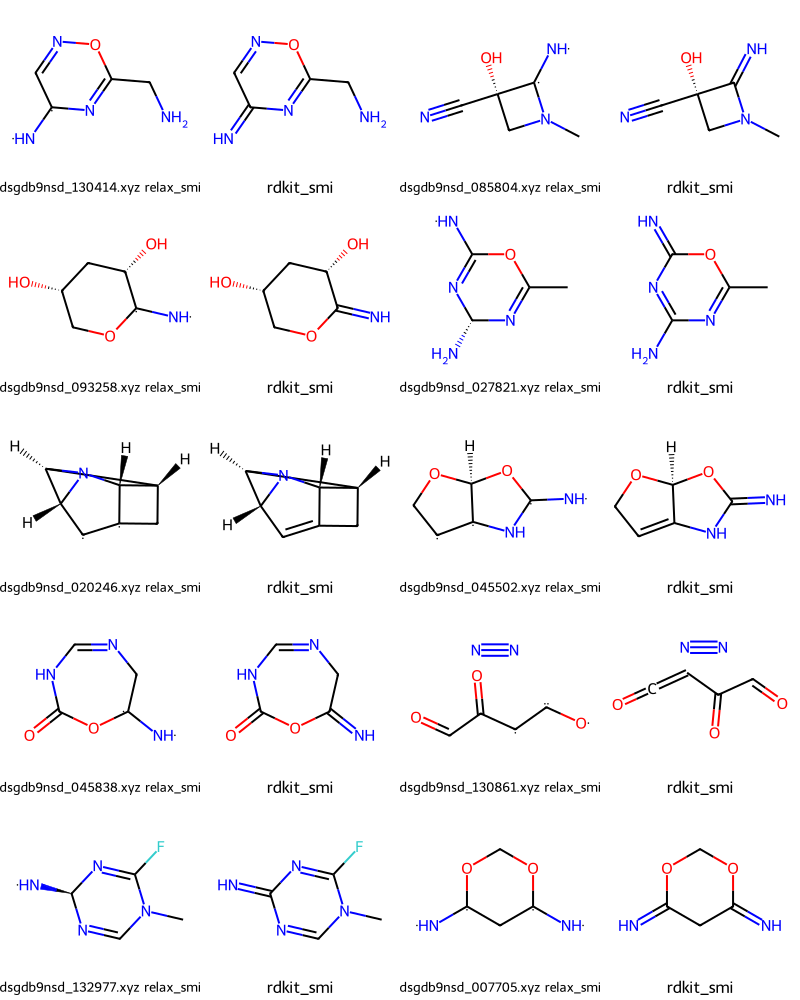

In [20]:
import os
failmols = []
nms = []
for fn,ismi,osmi in relax_fails:
    im = Chem.MolFromSmiles(ismi)
    om = Chem.MolFromSmiles(osmi)
    failmols.append(im)
    failmols.append(om)
    nms.append(f'{os.path.basename(fn)} relax_smi')
    nms.append('rdkit_smi')
Draw.MolsToGridImage(failmols[:20],molsPerRow=4,legends=nms)        

Those seem to be cases where we've assigned a multiple bond while the SMILES in the publication has a single bond with radicals on either side.

What about some of the 27 cases where we haven't reproduced the input GDB SMILES?

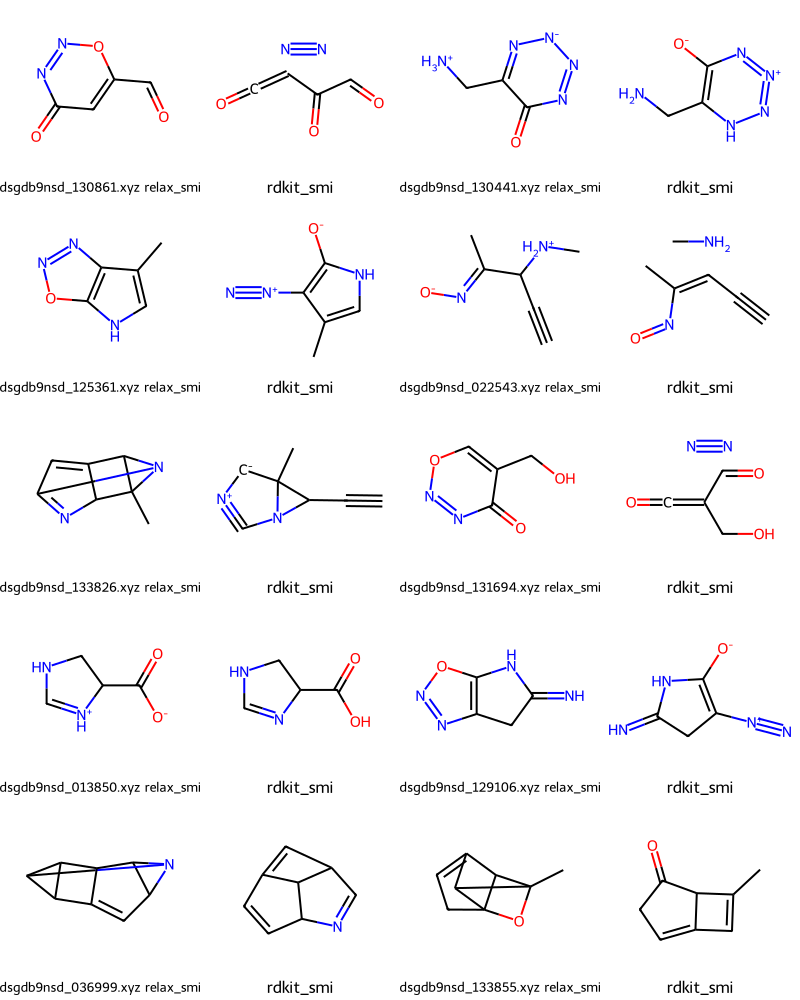

In [21]:
import os
failmols = []
nms = []
for fn,ismi,osmi in gdb_fails:
    im = Chem.MolFromSmiles(ismi)
    om = Chem.MolFromSmiles(osmi)
    failmols.append(im)
    failmols.append(om)
    nms.append(f'{os.path.basename(fn)} relax_smi')
    nms.append('rdkit_smi')
Draw.MolsToGridImage(failmols[:20],molsPerRow=4,legends=nms)        

Let's look at a couple of those:

In [22]:
ind,gdb_smi,relax_smi = cleanup_qm9_xyz('/local/QM9/dsgdb9nsd_129106.xyz')
raw_mol = Chem.MolFromXYZBlock(ind)
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol,charge=0)
conn_mol
draw_with_spheres(conn_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [23]:
ind,gdb_smi,relax_smi = cleanup_qm9_xyz('/local/QM9/dsgdb9nsd_133855.xyz')
raw_mol = Chem.MolFromXYZBlock(ind)
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol,charge=0)
conn_mol
draw_with_spheres(conn_mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Those are clearly cases where the QM optimization has yielded a completely different structure from what they started with.

I'm sure we'll end up finding (and fixing) issues once more people start using the code, but I think these results show that the new functionality in `rdDetermineBonds` works quite well!

# Benchmarking the code

The last question I had, and I will definitely stop after this, is how long it takes to run the code. Let's check that.

I just want to time `DetermineBonds()` part, so let's construct the molecules in advance:

In [24]:
from rdkit import rdBase
with rdBase.BlockLogs():
    tmols = []
    for fn,ind,gdb_smi,relax_smi in qm9_data:
        # the RDKit can't parse some of the SMILES from QM9... skip those
        mol = Chem.MolFromXYZBlock(ind)
        if mol is None:
            continue
        tmols.append(mol)
len(tmols)

9991

In [25]:
%timeit [rdDetermineBonds.DetermineBonds(m,charge=0) for m in tmols]

646 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can do almost 10K molecules in 646 ms, that's about 65 μs per molecule. So running `DetermineBonds()` shouldn't be a bottleneck in any workflows. :-)